In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#read data

#Please change folder before running script!
folder = "/Users/BharathiSrinivasan/Documents/Python/MoBerries_Test/"
df = pd.read_csv(folder + "SentimentAnalysisDataset.csv", error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


In [3]:
df.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [4]:
df.Sentiment.value_counts()

1    790177
0    788435
Name: Sentiment, dtype: int64

#### Data is not skewed (No class imbalance)

In [5]:
df['tweet_len'] = [len(t) for t in df.SentimentText]

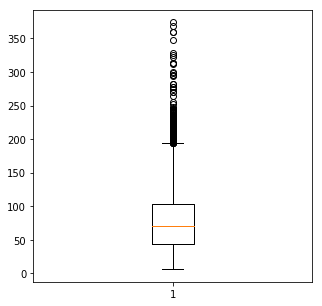

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.tweet_len)
plt.show()

### Cleaning Data

In [5]:
# Stopwords
from nltk.corpus import stopwords
stop = stopwords.words("english")
df['sentiment1']= df['SentimentText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [6]:
#Stemming
from nltk.stem import PorterStemmer
ps = PorterStemmer()
df['sentiment2']= df['sentiment1'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

In [7]:
#Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer
lemm = WordNetLemmatizer()
df['sentiment3']= df['sentiment2'].apply(lambda x: ' '.join([lemm.lemmatize(word,'v') for word in x.split()]))

In [8]:
#Removing tags and special characters
import re
df['sentiment4']= df['sentiment3'].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", word) for word in x.split()))

In [9]:
df['new_len'] = [len(t) for t in df.sentiment4]

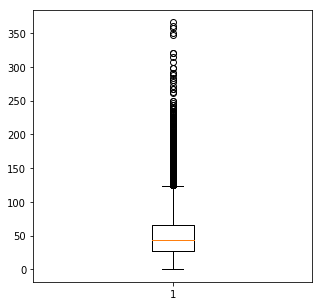

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.new_len)
plt.show()

In [12]:
df.drop(['ItemID','SentimentSource','SentimentText','new_len','sentiment1','sentiment2','sentiment3'],axis=1,inplace=True)

In [13]:
df.rename(index=str, columns={"sentiment4": "text"}, inplace = True)

In [33]:
df.head()

,Sentiment,text
0,0,sad apl friend
1,0,I miss new moon trailer
2,1,omg alreadi 7 30 O
3,0,omgaga Im sooo im gunna cry i v dentist s...
4,0,think mi bf cheat me t t


In [15]:
df.to_csv('cleaned_data.csv')

### Visualise Frequent Words

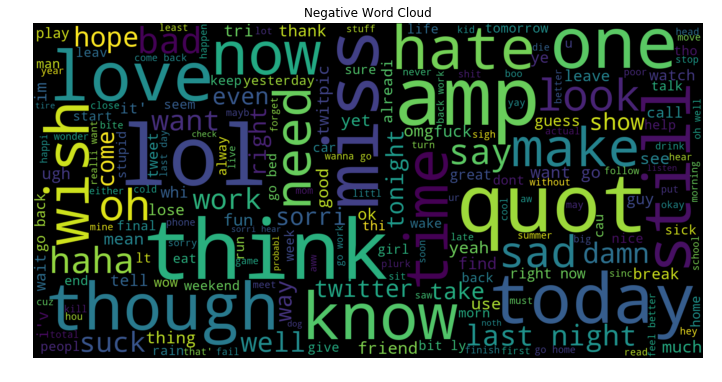

In [14]:
neg_tweets = df[df.Sentiment == 0]
neg_string = []

for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Negative Word Cloud')
plt.axis("off")
plt.show()

### Some words like 'sad', 'hate', 'miss' are highlighted but so are neutral and positive words

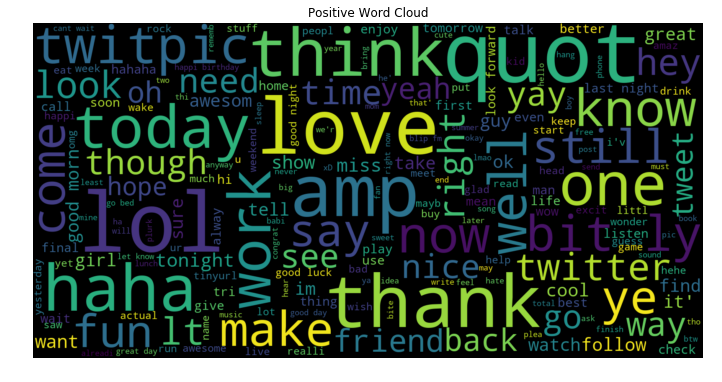

In [15]:
pos_tweets = df[df.Sentiment == 1]
pos_string = []

for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Positive Word Cloud')
plt.axis("off")
plt.show()

In [2]:
#df = pd.read_csv('cleaned_data.csv')

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(df.text)

In [50]:
pos_doc_matrix = vect.transform(df[df.Sentiment == 1].text)
pos_tf = np.sum(pos_doc_matrix,axis=0)
pos = np.squeeze(np.asarray(pos_tf))

In [51]:
neg_doc_matrix = vect.transform(df[df.Sentiment == 0].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))

In [52]:
term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()

In [53]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']

In [54]:
term_freq_df.sort_values(by='positive', ascending=False).iloc[:10]

,negative,positive,total
get,94796,76499,171295
go,90226,64234,154460
good,29240,61238,90478
love,21059,59196,80255
day,47146,52110,99256
it,48265,50766,99031
quot,26106,46221,72327
you,21354,44638,65992
thank,6659,43214,49873
like,42773,40156,82929


### Most positive words : get, go, good, love, day, it, quot, you , thank, like

In [55]:
term_freq_df.sort_values(by='negative', ascending=False).iloc[:10]

,negative,positive,total
get,94796,76499,171295
go,90226,64234,154460
work,55273,27105,82378
it,48265,50766,99031
day,47146,52110,99256
miss,46676,9091,55767
like,42773,40156,82929
want,39572,16684,56256
today,38102,29993,68095
feel,35519,13869,49388


### Words most frequently used in negative tweets: get, go, work, it, day, miss, like, want, today, feel

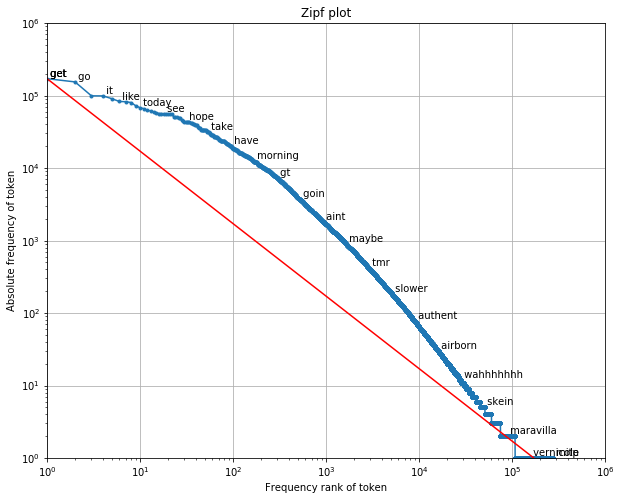

In [61]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(10,8))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)

for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

plt.show()

### Sentiment Classification

In [63]:
#Test - train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.Sentiment, test_size=0.25, random_state=42, shuffle = True)

In [64]:
# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)

In [65]:
#Simple logistic regression to classify
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [67]:
#Model Performance 
from sklearn.metrics import roc_curve, roc_auc_score, auc

predictions = model.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.7764482905207108


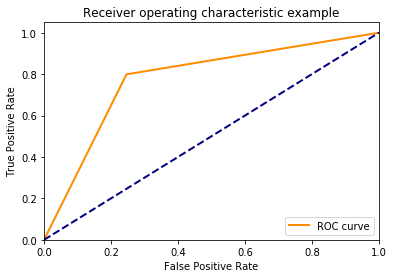

In [70]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.figure()
lw = 2
plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
         lw=lw, label='ROC curve' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Term frequencies were used to train a simple classifier (Logistic Regression) and the resulting AUC is 0.776

### Possible Improvements:

#### Text Processing:
- Term frequencies would scale up frequent words and scale down rare words. But frequently occuring words are not a good discriminator. Tf-IDF is a possible improvement
- N Grams use a combination of tokens during classification
- Word embeddings (doc2vec) using neural networks learn features most effectively

#### Model Training:
- Cross validation needs to be performed to find lowest error on all parts of the dataset and to find a reliable model

#### Classification Model:
- Naive Bayes and SVM are better classifiers. But best results can be acheived with Randome Forests and Neural Networks with embeddings